In [1]:
# Cell 1 — Mount Drive & paths
from google.colab import drive
drive.mount('/content/drive')

import os
base_path = "/content/drive/MyDrive/AgriYield_Data"  # change if your folder is different
crop_path = os.path.join(base_path, "Crop_recommendation.csv")
fao_path  = os.path.join(base_path, "FAOSTAT_data_en_11-19-2025.csv")

print("Paths used:")
print(" crop:", crop_path)
print(" fao: ", fao_path)
print("\nFiles exist?")
print(" Crop:", os.path.exists(crop_path))
print(" FAO: ", os.path.exists(fao_path))

if not (os.path.exists(crop_path) and os.path.exists(fao_path)):
    print("\nFolder listing for debugging:")
    try:
        for f in os.listdir(base_path):
            print(" ", f)
    except Exception as e:
        print(" Could not list folder:", e)


Mounted at /content/drive
Paths used:
 crop: /content/drive/MyDrive/AgriYield_Data/Crop_recommendation.csv
 fao:  /content/drive/MyDrive/AgriYield_Data/FAOSTAT_data_en_11-19-2025.csv

Files exist?
 Crop: True
 FAO:  True


In [2]:
# Cell 2 — Load CSVs and inspect
import pandas as pd
from IPython.display import display

crop = pd.read_csv(crop_path)
fao  = pd.read_csv(fao_path)

print("Crop shape:", crop.shape)
print("Crop columns:", crop.columns.tolist())
display(crop.head())

print("\nFAO shape:", fao.shape)
print("FAO columns:", fao.columns.tolist())
display(fao.head())


Crop shape: (2200, 8)
Crop columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice



FAO shape: (5940, 15)
FAO columns: ['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code', 'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Year', 'Unit', 'Value', 'Flag', 'Flag Description', 'Note']


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN
1,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,kg/ha,484.0,A,Official figure,NaN
2,QCL,Crops and livestock products,356,India,5510,Production,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,t,166692.0,A,Official figure,NaN
3,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,ha,569271.0,A,Official figure,NaN
4,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,kg/ha,430.3,A,Official figure,NaN


In [3]:
# Cell 3 — Drop specified metadata columns (safe drop)
cols_to_drop_variants = [
    "Domain", "Domain Code", "domain", "domain code",
    "Area", "Area Code (M49)", "Area Code", "area", "area code",
    "Element Code", "element code",
    "Item Code (CPC)", "Item Code", "item code",
    "Year Code", "Year", "year code", "year",
    "Unit", "unit",
    "Flag", "Flag Description", "flag description", "Note", "note"
]

# Drop only if present, ignore errors otherwise
fao_clean = fao.drop(columns=[c for c in cols_to_drop_variants if c in fao.columns], errors='ignore').copy()

print("Dropped metadata columns (if they existed).")
print("Original FAO shape:", fao.shape)
print("FAO shape after drop:", fao_clean.shape)
print("\nRemaining FAO columns:", fao_clean.columns.tolist())
display(fao_clean.head())


Dropped metadata columns (if they existed).
Original FAO shape: (5940, 15)
FAO shape after drop: (5940, 3)

Remaining FAO columns: ['Element', 'Item', 'Value']


,Element,Item,Value
0,Area harvested,"Anise, badian, coriander, cumin, caraway, fenn...",344434.0
1,Yield,"Anise, badian, coriander, cumin, caraway, fenn...",484.0
2,Production,"Anise, badian, coriander, cumin, caraway, fenn...",166692.0
3,Area harvested,"Anise, badian, coriander, cumin, caraway, fenn...",569271.0
4,Yield,"Anise, badian, coriander, cumin, caraway, fenn...",430.3


In [4]:
# Cell 4 — Normalize crop dataset names (crop_clean)
# ensure we have a Crop column (many datasets use label)
if "label" in crop.columns and "Crop" not in crop.columns:
    crop = crop.rename(columns={"label":"Crop"})

if "Crop" not in crop.columns:
    # try to find possible column
    possible = [c for c in crop.columns if c.lower() in ("crop","label","item")]
    if possible:
        crop = crop.rename(columns={possible[0]:"Crop"})
    else:
        raise KeyError("Could not find crop column in crop dataset. Columns: " + str(crop.columns.tolist()))

crop['crop_clean'] = crop['Crop'].astype(str).str.lower().str.strip()
print("Crop shape:", crop.shape)
print("Unique crop count (sample 50):", len(crop['crop_clean'].unique()))
display(sorted(list(crop['crop_clean'].unique()))[:50])
display(crop.head())


Crop shape: (2200, 9)
Unique crop count (sample 50): 22


['apple',
 'banana',
 'blackgram',
 'chickpea',
 'coconut',
 'coffee',
 'cotton',
 'grapes',
 'jute',
 'kidneybeans',
 'lentil',
 'maize',
 'mango',
 'mothbeans',
 'mungbean',
 'muskmelon',
 'orange',
 'papaya',
 'pigeonpeas',
 'pomegranate',
 'rice',
 'watermelon']

,N,P,K,temperature,humidity,ph,rainfall,Crop,crop_clean
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,rice


In [5]:
# Cell 5 — detect FAO item column (Item / Item name / Crop)
import re
fao_proc = fao_clean.copy()

# find a column that likely contains the crop names
possible_item_cols = [c for c in fao_proc.columns if c.lower().strip() in ("item","item ","item name","crop","itemname","item ")]
# fallback search by substring
if not possible_item_cols:
    possible_item_cols = [c for c in fao_proc.columns if "item" in c.lower() or "crop" in c.lower()]

if not possible_item_cols:
    raise KeyError("Could not automatically find a FAO column for item names. Columns: " + str(fao_proc.columns.tolist()))

item_col = possible_item_cols[0]
print("Using FAO column for crop names:", item_col)

def preprocess_item(x):
    s = str(x).lower()
    s = re.sub(r"\(.*?\)", "", s)   # remove parentheses content
    s = s.strip()
    return s

fao_proc['Item_clean_raw'] = fao_proc[item_col].apply(preprocess_item)
print("\nSample cleaned Item values (first 10):")
display(fao_proc[[item_col,'Item_clean_raw']].head(10))


Using FAO column for crop names: Item

Sample cleaned Item values (first 10):


,Item,Item_clean_raw
0,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."
1,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."
2,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."
3,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."
4,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."
5,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."
6,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."
7,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."
8,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."
9,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn..."


In [6]:
# Cell 6 — split on commas and explode
fao_proc['Item_list'] = fao_proc['Item_clean_raw'].str.split(',')

fao_exp = fao_proc.explode('Item_list').copy()

# clean exploded fragments: strip, remove non-letters, collapse spaces
fao_exp['crop_clean'] = (
    fao_exp['Item_list']
    .astype(str)
    .str.strip()
    .str.replace(r"[^a-zA-Z ]", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

print("Exploded FAO shape (before filtering):", fao_exp.shape)
print("Sample exploded rows:")
display(fao_exp[[item_col,'Item_clean_raw','Item_list','crop_clean']].head(20))

print("\nUnique exploded fragments (sample 50):")
display(sorted(list(set(fao_exp['crop_clean'])))[0:50])


Exploded FAO shape (before filtering): (9088, 6)
Sample exploded rows:


,Item,Item_clean_raw,Item_list,crop_clean
0,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",anise,anise
0,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",badian,badian
0,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",coriander,coriander
0,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",cumin,cumin
0,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",caraway,caraway
0,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",fennel and juniper berries,fennel and juniper berries
0,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",raw,raw
1,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",anise,anise
1,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",badian,badian
1,"Anise, badian, coriander, cumin, caraway, fenn...","anise, badian, coriander, cumin, caraway, fenn...",coriander,coriander



Unique exploded fragments (sample 50):


['and other textile bast fibres',
 'anise',
 'apples',
 'apricots',
 'areca nuts',
 'badian',
 'bananas',
 'barley',
 'beans',
 'cabbages',
 'cantaloupes and other melons',
 'caraway',
 'cardamoms',
 'carrots and turnips',
 'cashew nuts',
 'cassava',
 'castor oil seeds',
 'cauliflowers and broccoli',
 'cherries',
 'chick peas',
 'chillies and peppers',
 'clementines',
 'cocoa beans',
 'coconuts',
 'coffee',
 'coir',
 'coriander',
 'cucumbers and gherkins',
 'cumin',
 'dry',
 'eggplants',
 'excluding shelled',
 'fennel and juniper berries',
 'figs',
 'fresh',
 'fresh nec',
 'ginger',
 'grapes',
 'green',
 'green garlic',
 'groundnuts',
 'guavas and mangosteens',
 'in shell',
 'jute',
 'kenaf',
 'lemons and limes',
 'lentils',
 'lettuce and chicory',
 'linseed',
 'mace']

In [7]:
# Cell 7 — Filter exploded rows to only those crop_clean present in crop dataset
valid_crops = set(crop['crop_clean'])
print("Valid crop count in crop dataset:", len(valid_crops))

fao_exp_valid = fao_exp[fao_exp['crop_clean'].isin(valid_crops)].copy()
fao_exp_valid = fao_exp_valid[fao_exp_valid['crop_clean'].notna() & (fao_exp_valid['crop_clean']!="")]

print("Exploded FAO AFTER filtering to valid crops shape:", fao_exp_valid.shape)
print("Unique valid crops kept:", sorted(fao_exp_valid['crop_clean'].unique()))
display(fao_exp_valid.head(30))


Valid crop count in crop dataset: 22
Exploded FAO AFTER filtering to valid crops shape: (360, 6)
Unique valid crops kept: ['coffee', 'grapes', 'jute', 'maize', 'rice']


,Element,Item,Value,Item_clean_raw,Item_list,crop_clean
1434,Area harvested,"Coffee, green",308433.0,"coffee, green",coffee,coffee
1435,Yield,"Coffee, green",946.7,"coffee, green",coffee,coffee
1436,Production,"Coffee, green",292000.0,"coffee, green",coffee,coffee
1437,Area harvested,"Coffee, green",313934.0,"coffee, green",coffee,coffee
1438,Yield,"Coffee, green",958.8,"coffee, green",coffee,coffee
1439,Production,"Coffee, green",301000.0,"coffee, green",coffee,coffee
1440,Area harvested,"Coffee, green",320737.0,"coffee, green",coffee,coffee
1441,Yield,"Coffee, green",938.5,"coffee, green",coffee,coffee
1442,Production,"Coffee, green",301000.0,"coffee, green",coffee,coffee
1443,Area harvested,"Coffee, green",320615.0,"coffee, green",coffee,coffee


In [8]:
# Cell 8 — Filter to Element == 'Yield' (if that column exists)
elem_col = None
for c in fao_exp_valid.columns:
    if c.lower().strip() == "element":
        elem_col = c
        break

if elem_col:
    print("Element column found:", elem_col)
    print("Value counts for Element (sample):")
    display(fao_exp_valid[elem_col].value_counts().head(20))
    fao_yield_exp = fao_exp_valid[fao_exp_valid[elem_col] == "Yield"].copy()
else:
    print("No 'Element' column detected. Keeping all exploded rows (warning).")
    fao_yield_exp = fao_exp_valid.copy()

print("FAO exploded yield shape:", fao_yield_exp.shape)
display(fao_yield_exp.head(20))


Element column found: Element
Value counts for Element (sample):


,count
Element,
Area harvested,120
Yield,120
Production,120


FAO exploded yield shape: (120, 6)


,Element,Item,Value,Item_clean_raw,Item_list,crop_clean
1435,Yield,"Coffee, green",946.7,"coffee, green",coffee,coffee
1438,Yield,"Coffee, green",958.8,"coffee, green",coffee,coffee
1441,Yield,"Coffee, green",938.5,"coffee, green",coffee,coffee
1444,Yield,"Coffee, green",858.6,"coffee, green",coffee,coffee
1447,Yield,"Coffee, green",832.0,"coffee, green",coffee,coffee
1450,Yield,"Coffee, green",826.5,"coffee, green",coffee,coffee
1453,Yield,"Coffee, green",802.7,"coffee, green",coffee,coffee
1456,Yield,"Coffee, green",839.6,"coffee, green",coffee,coffee
1459,Yield,"Coffee, green",760.5,"coffee, green",coffee,coffee
1462,Yield,"Coffee, green",748.4,"coffee, green",coffee,coffee


In [9]:
# Cell 9 — keep targeted columns from FAO (Value is target)
keep_candidates = ['crop_clean','Value','Year','Area','Area Code (M49)','Area Code','Item Code (CPC)','Item Code']
keep_cols = [c for c in keep_candidates if c in fao_yield_exp.columns]
# ensure Value exists
if 'Value' not in fao_yield_exp.columns:
    # try case-insensitive search
    val_cols = [c for c in fao_yield_exp.columns if c.lower()=="value"]
    if val_cols:
        keep_cols.append(val_cols[0])
    else:
        raise KeyError("No 'Value' column detected in FAO (this is the target). Columns: " + str(fao_yield_exp.columns))

# include crop_clean
if 'crop_clean' not in keep_cols and 'crop_clean' in fao_yield_exp.columns:
    keep_cols = ['crop_clean'] + keep_cols

fao_yield_final = fao_yield_exp[keep_cols].copy()
print("FAO final columns kept:", fao_yield_final.columns.tolist())
print("FAO final shape:", fao_yield_final.shape)
display(fao_yield_final.head(20))


FAO final columns kept: ['crop_clean', 'Value']
FAO final shape: (120, 2)


,crop_clean,Value
1435,coffee,946.7
1438,coffee,958.8
1441,coffee,938.5
1444,coffee,858.6
1447,coffee,832.0
1450,coffee,826.5
1453,coffee,802.7
1456,coffee,839.6
1459,coffee,760.5
1462,coffee,748.4


In [10]:
# Cell 10 — Merge on crop_clean
merged = pd.merge(fao_yield_final, crop, on="crop_clean", how="inner", suffixes=("_fao","_crop"))

print("Merged shape:", merged.shape)
print("Merged columns:", merged.columns.tolist())
display(merged.head(30))

# quick: how many unique crops in merged?
print("\nUnique crops in merged:", sorted(merged['crop_clean'].unique()))


Merged shape: (12000, 10)
Merged columns: ['crop_clean', 'Value', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'Crop']


,crop_clean,Value,N,P,K,temperature,humidity,ph,rainfall,Crop
0,coffee,946.7,91,21,26,26.333780,57.364700,7.261314,191.654941,coffee
1,coffee,946.7,107,21,26,26.452885,55.322227,7.235070,144.686134,coffee
2,coffee,946.7,83,38,35,25.708227,52.886671,7.189156,136.732509,coffee
3,coffee,946.7,108,24,31,24.128325,56.181077,6.431900,147.275782,coffee
4,coffee,946.7,116,28,34,23.443723,60.395233,6.423211,122.210325,coffee
5,coffee,946.7,116,23,25,23.412371,52.269947,6.869720,139.367075,coffee
6,coffee,946.7,109,31,27,23.059519,50.406094,6.973840,164.497187,coffee
7,coffee,946.7,89,25,34,23.078954,63.658615,7.184802,129.876544,coffee
8,coffee,946.7,118,18,32,27.649611,51.110440,6.351824,122.839282,coffee
9,coffee,946.7,111,32,34,25.467437,69.351612,6.392048,171.376446,coffee



Unique crops in merged: ['coffee', 'grapes', 'jute', 'maize', 'rice']


In [11]:
# Cell 11 — Remove nulls and duplicates
print("Before cleaning: shape", merged.shape)
nulls_before = merged.isnull().sum()
print("Nulls before (top 10):")
display(nulls_before.sort_values(ascending=False).head(10))

merged_clean = merged.dropna().copy()
print("After dropna: shape", merged_clean.shape)

merged_clean = merged_clean.drop_duplicates().copy()
print("After drop_duplicates: shape", merged_clean.shape)

print("\nNulls after cleaning (should be 0):")
display(merged_clean.isnull().sum())
display(merged_clean.head())


Before cleaning: shape (12000, 10)
Nulls before (top 10):


,0
crop_clean,0
Value,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
Crop,0


After dropna: shape (12000, 10)
After drop_duplicates: shape (11900, 10)

Nulls after cleaning (should be 0):


,0
crop_clean,0
Value,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
Crop,0


,crop_clean,Value,N,P,K,temperature,humidity,ph,rainfall,Crop
0,coffee,946.7,91,21,26,26.333780,57.364700,7.261314,191.654941,coffee
1,coffee,946.7,107,21,26,26.452885,55.322227,7.235070,144.686134,coffee
2,coffee,946.7,83,38,35,25.708227,52.886671,7.189156,136.732509,coffee
3,coffee,946.7,108,24,31,24.128325,56.181077,6.431900,147.275782,coffee
4,coffee,946.7,116,28,34,23.443723,60.395233,6.423211,122.210325,coffee


Numeric cols for boxplots: ['Value', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


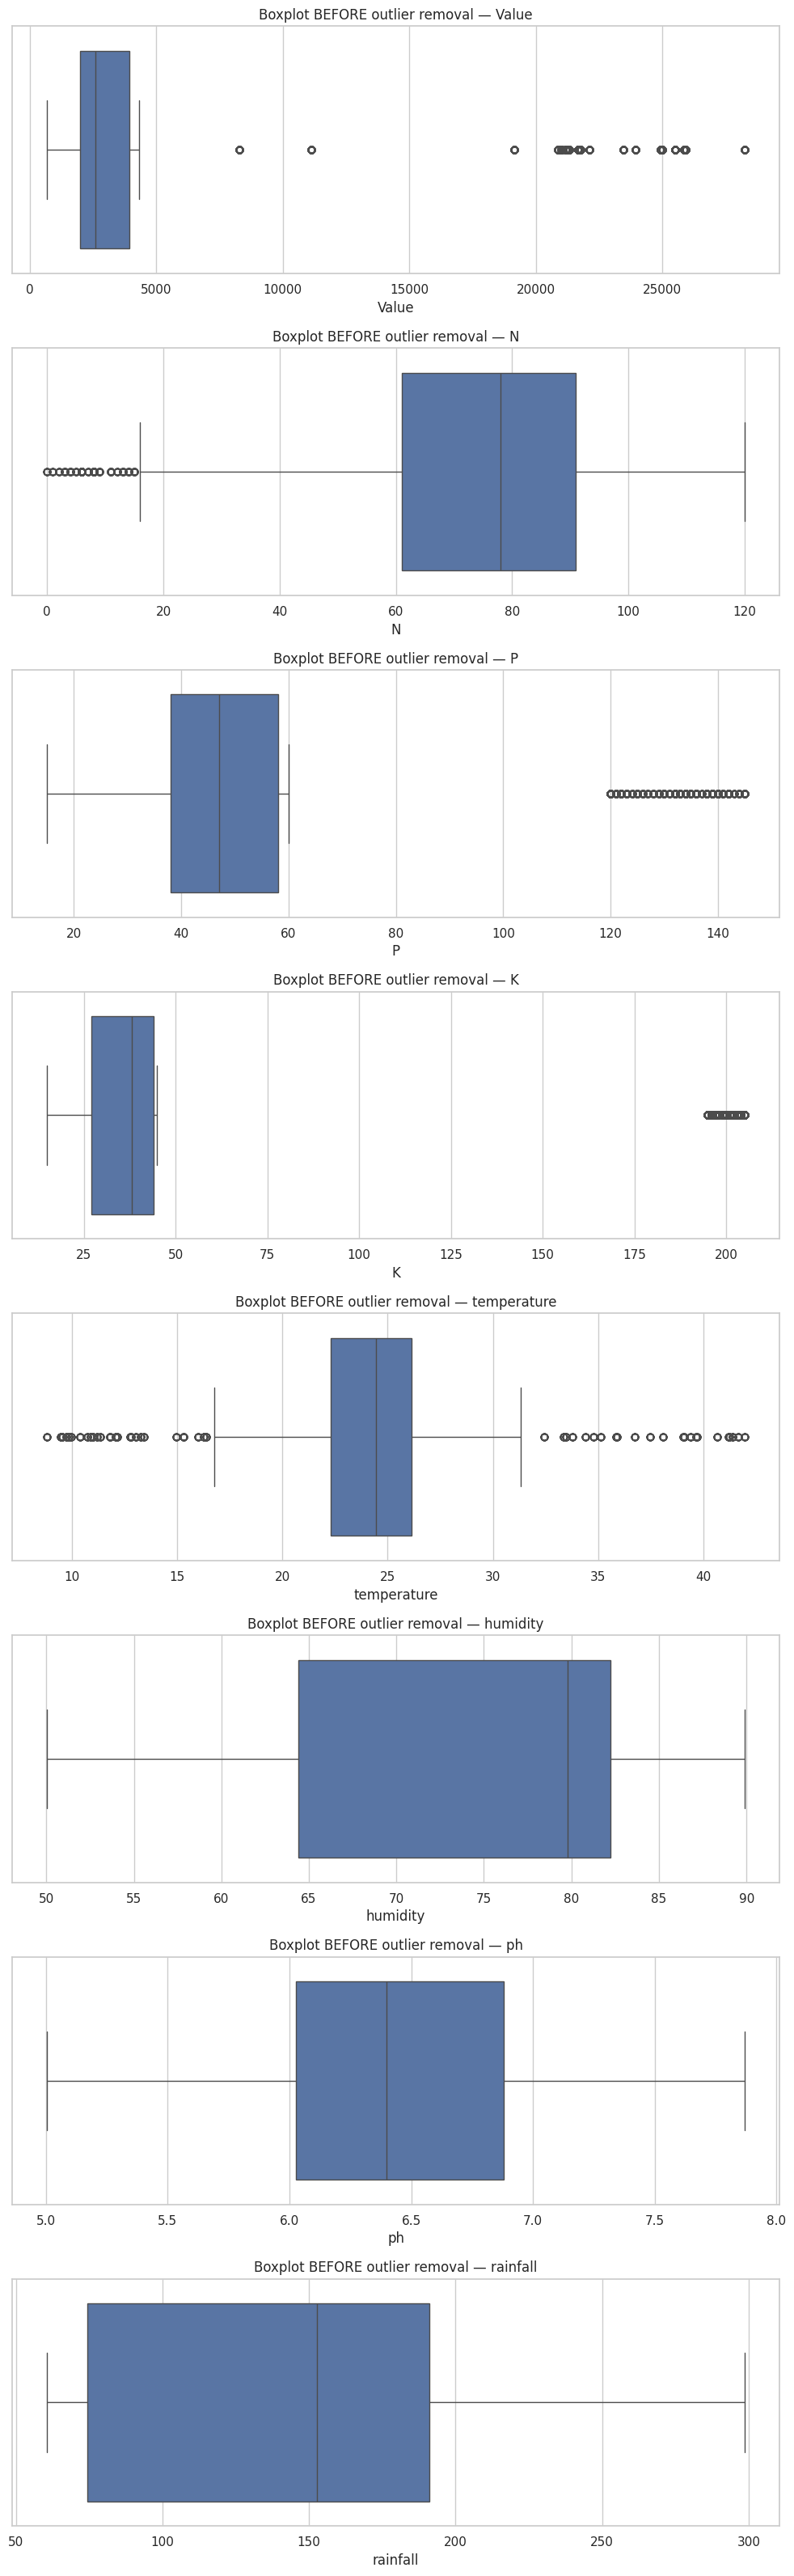

In [12]:
# Cell 12 — Boxplots before outlier removal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Find numeric columns we care about
wanted = ['Value','N','P','K','temperature','humidity','ph','rainfall']
numeric_cols = []
for w in wanted:
    matches = [c for c in merged_clean.columns if c.lower()==w.lower()]
    if matches:
        numeric_cols.append(matches[0])

print("Numeric cols for boxplots:", numeric_cols)
if not numeric_cols:
    print("No expected numeric columns found; available numeric columns:")
    display(merged_clean.select_dtypes('number').columns.tolist())
else:
    plt.figure(figsize=(10, 4*len(numeric_cols)))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols),1,i)
        sns.boxplot(x=merged_clean[col])
        plt.title(f"Boxplot BEFORE outlier removal — {col}")
    plt.tight_layout()
    plt.show()


In [13]:
# Cell 13 — IQR outlier removal on the numeric columns detected above
import numpy as np

if not numeric_cols:
    print("No numeric cols detected; skipping outlier removal.")
    merged_clean_iqr = merged_clean.copy()
else:
    df = merged_clean.copy()
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((df[numeric_cols] < (Q1 - 1.5*IQR)) | (df[numeric_cols] > (Q3 + 1.5*IQR))).any(axis=1)
    before = df.shape[0]
    df_iqr = df[mask].copy()
    after = df_iqr.shape[0]
    print(f"Rows before outlier removal: {before}")
    print(f"Rows after outlier removal:  {after}")
    print(f"Rows removed: {before-after} ({(before-after)/before*100:.2f}%)")
    merged_clean_iqr = df_iqr.copy()
    display(merged_clean_iqr.head())


Rows before outlier removal: 11900
Rows after outlier removal:  9500
Rows removed: 2400 (20.17%)


,crop_clean,Value,N,P,K,temperature,humidity,ph,rainfall,Crop
0,coffee,946.7,91,21,26,26.333780,57.364700,7.261314,191.654941,coffee
1,coffee,946.7,107,21,26,26.452885,55.322227,7.235070,144.686134,coffee
2,coffee,946.7,83,38,35,25.708227,52.886671,7.189156,136.732509,coffee
3,coffee,946.7,108,24,31,24.128325,56.181077,6.431900,147.275782,coffee
4,coffee,946.7,116,28,34,23.443723,60.395233,6.423211,122.210325,coffee


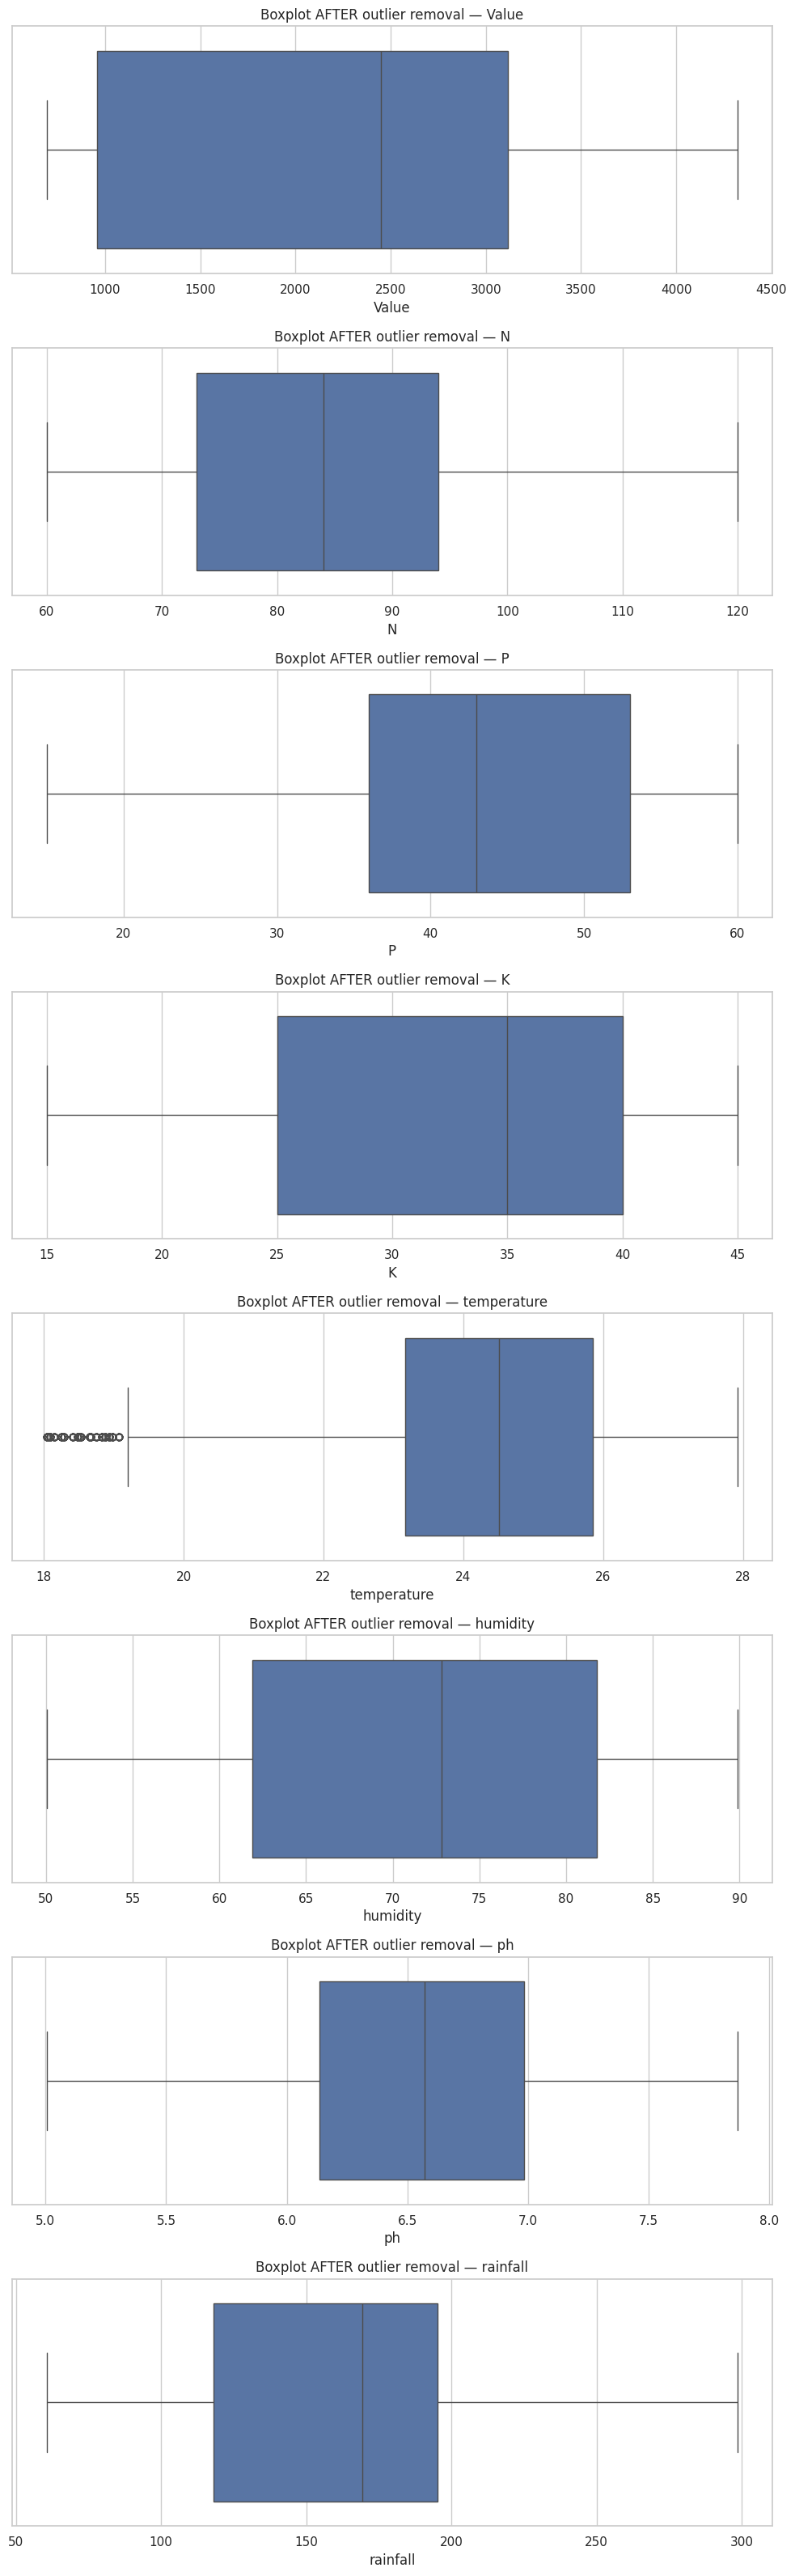

In [14]:
# Cell 14 — Boxplots after outlier removal
if numeric_cols and 'merged_clean_iqr' in globals():
    plt.figure(figsize=(10, 4*len(numeric_cols)))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols),1,i)
        sns.boxplot(x=merged_clean_iqr[col])
        plt.title(f"Boxplot AFTER outlier removal — {col}")
    plt.tight_layout()
    plt.show()
else:
    print("No cleaned dataset available for post-outlier plots.")


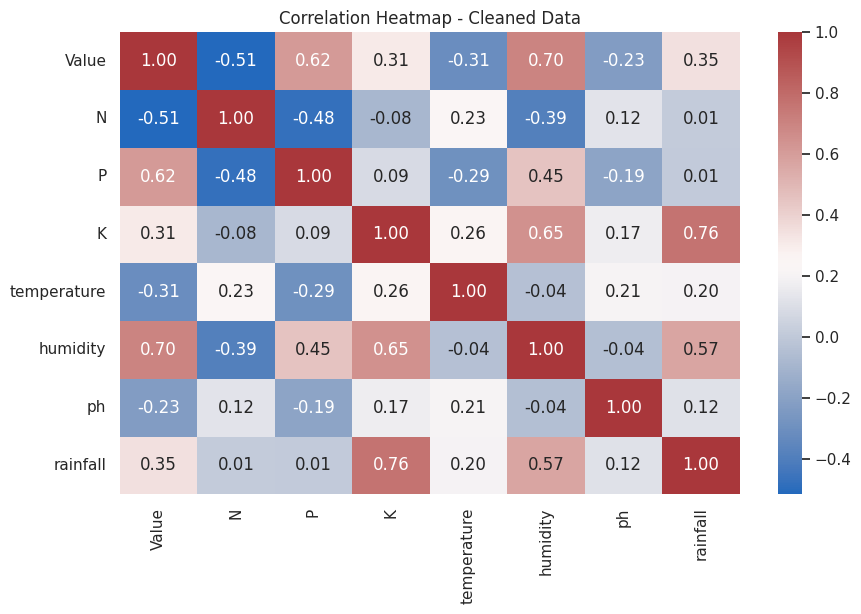

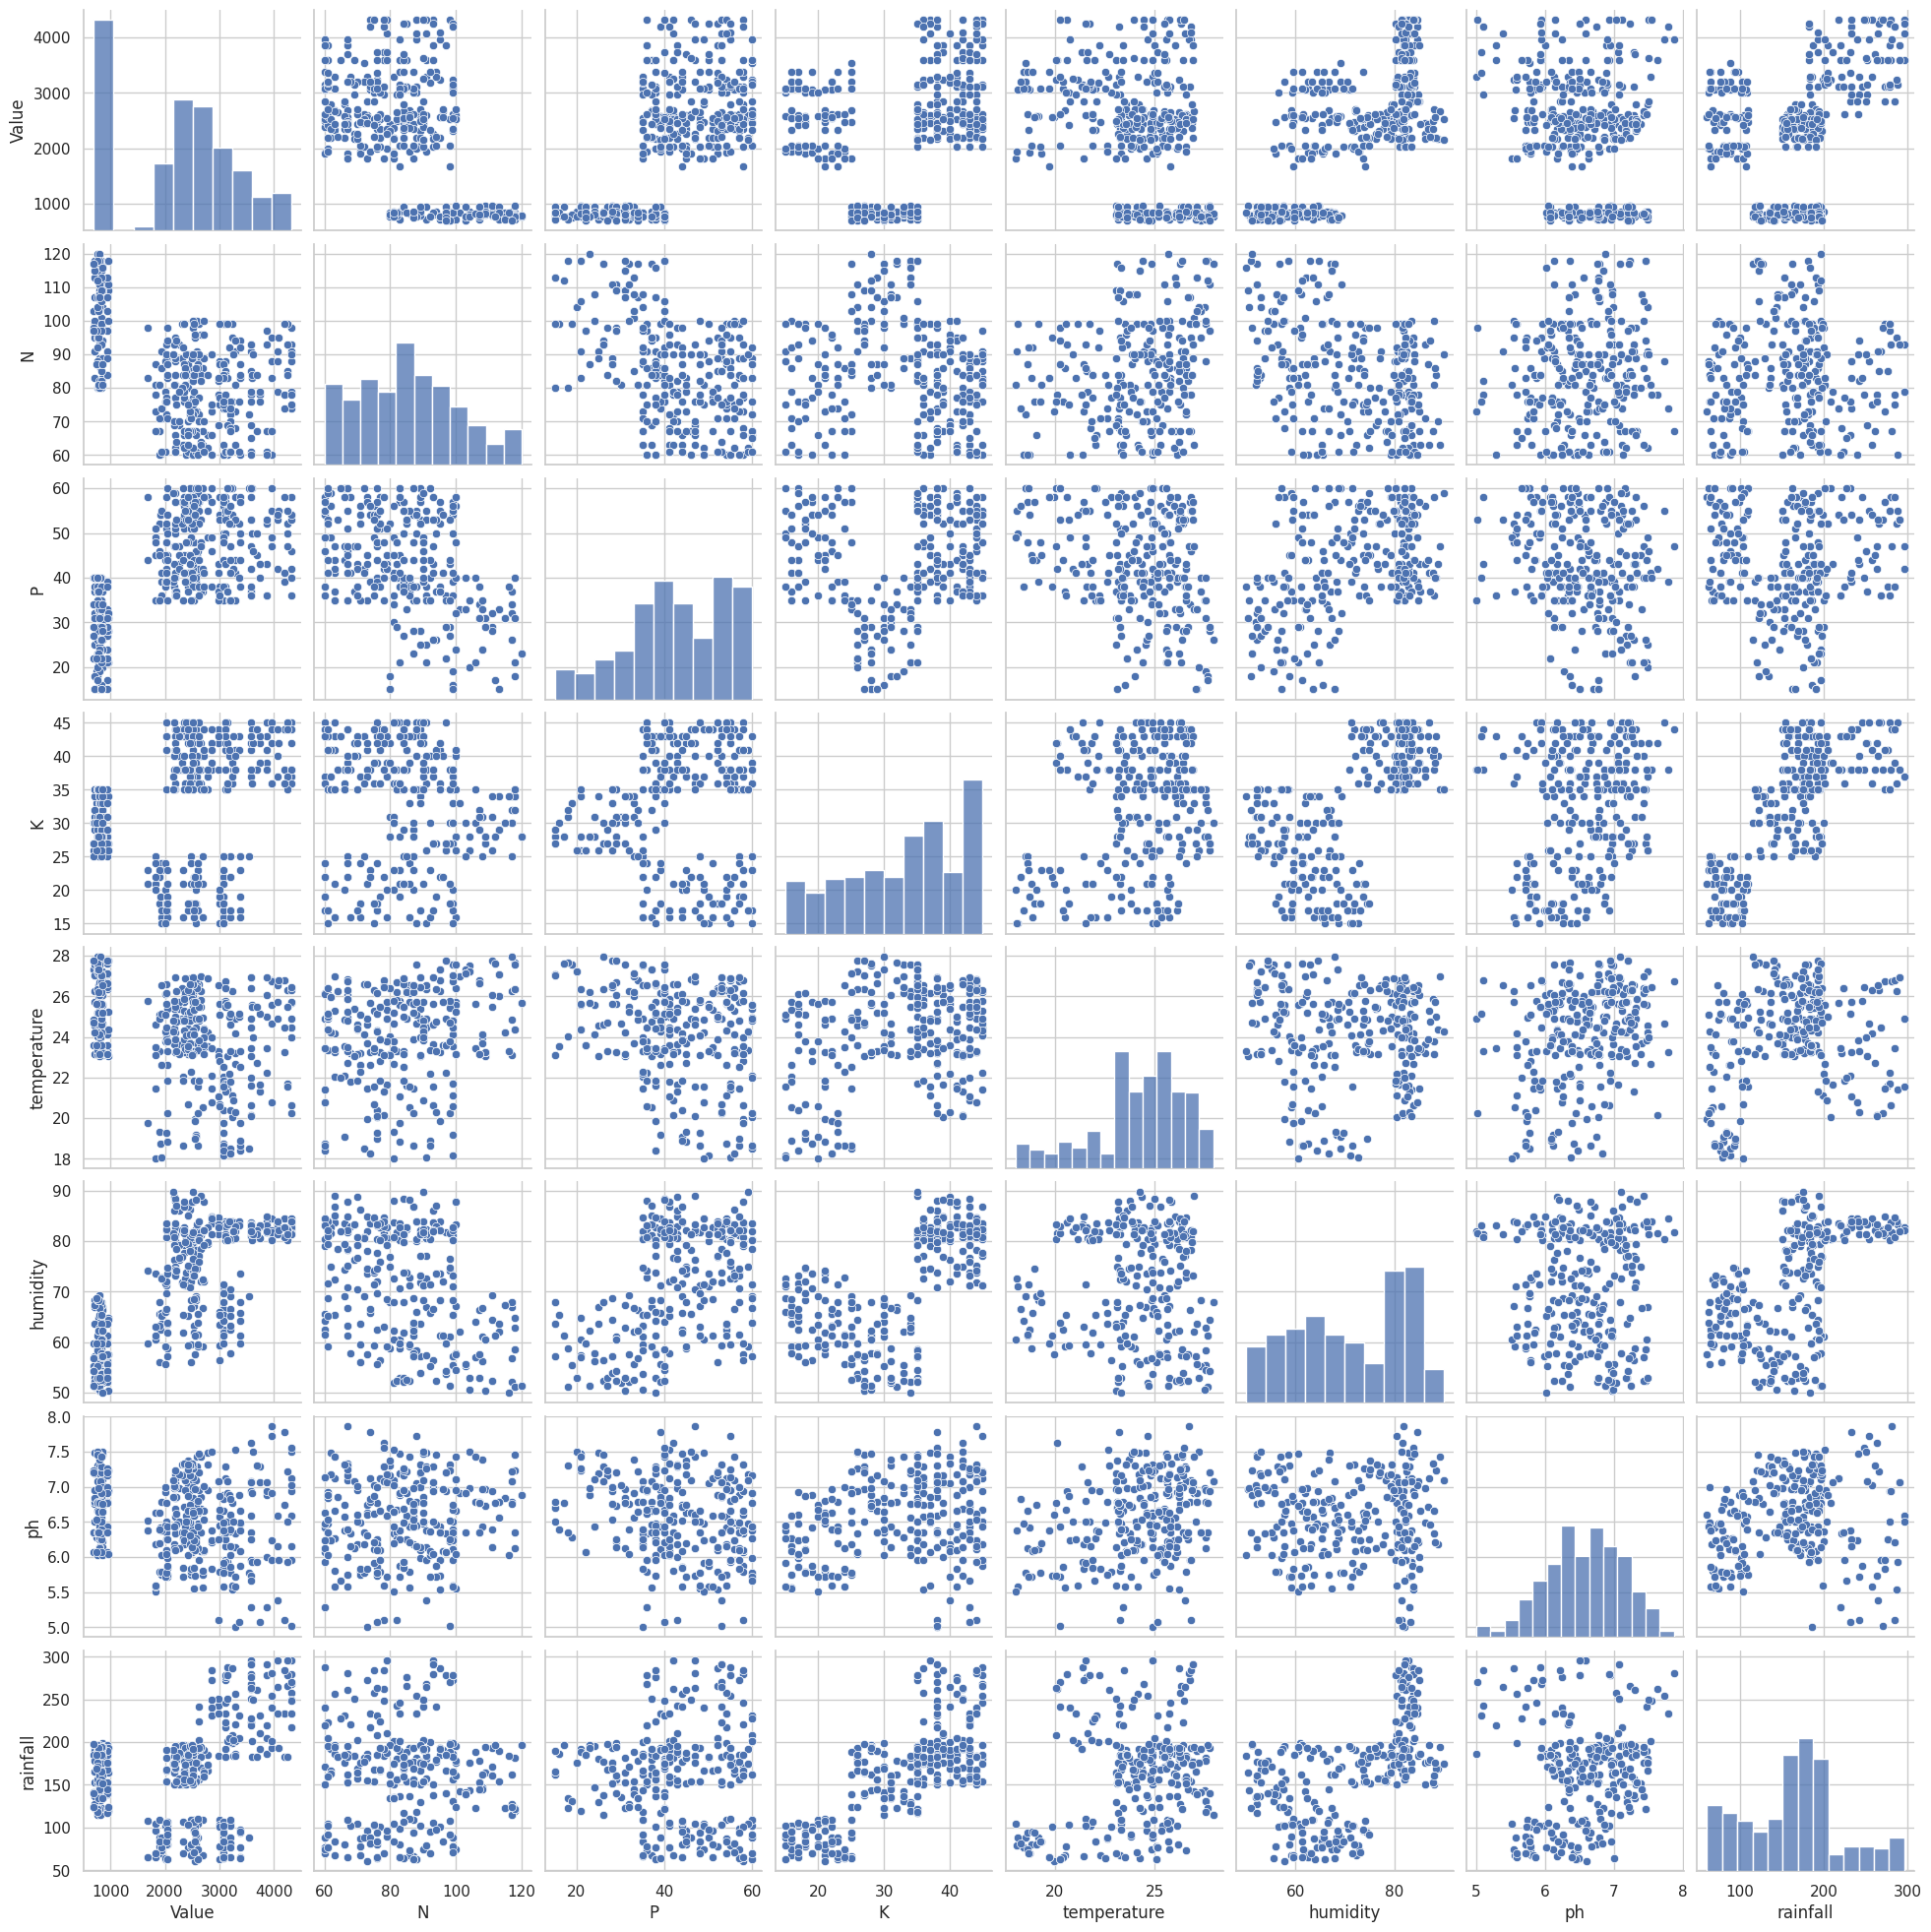

In [15]:
# Cell 15 — Correlation heatmap and pairplot
if numeric_cols and len(numeric_cols)>1:
    plt.figure(figsize=(10,6))
    sns.heatmap(merged_clean_iqr[numeric_cols].corr(), annot=True, fmt=".2f", cmap="vlag")
    plt.title("Correlation Heatmap - Cleaned Data")
    plt.show()

    sample = merged_clean_iqr[numeric_cols].sample(n=min(400, merged_clean_iqr.shape[0]), random_state=42)
    sns.pairplot(sample)
    plt.show()
else:
    print("Not enough numeric columns for heatmap/pairplot.")


In [16]:
# Cell 16 — Save final cleaned file
out_path = os.path.join(base_path, "merged_cleaned_final.csv")
merged_clean_iqr.to_csv(out_path, index=False)
print("Saved final cleaned merged dataset to:", out_path)
print("Final shape:", merged_clean_iqr.shape)


Saved final cleaned merged dataset to: /content/drive/MyDrive/AgriYield_Data/merged_cleaned_final.csv
Final shape: (9500, 10)
